In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.signal import resample
from signal_pross import (
    normalize_signal,
    detrend_w_poly,
    normalize_amplitude_to_1,
    n_moving_avg
)
from truth import IeeeGroundTruth

%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 6]

In [2]:
truths = []
for subject in range(1, 8):

    truth = IeeeGroundTruth(subject, 1, directory = 'channel_data3')  # basic method
    truth.align_rgb_bvp()
    truth.fill_nans()
    truth.process_rgb()
    truth.process_bvp()

    truths.append(truth)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


class RppgMl:
    
    def __init__(self, data, label_col = 'bvp', subject_col = 'subject', test_size = 0.2, random_state = 0):

        self.data = data
        self.label_col = label_col
        self.subject_col = subject_col
        self.test_size = test_size
        self.random_state = random_state

        self.X = self.data.drop(columns = [self.label_col, self.subject_col])
        self.y = self.data[self.label_col]
        
        (
            self.X_train, self.X_test,
            self.y_train, self.y_test
        ) = train_test_split(self.X, self.y, test_size = self.test_size, random_state = self.random_state)

        self.X_train = self.X_train.to_numpy()
        self.X_test = self.X_test.to_numpy()
        self.y_train = self.y_train.to_numpy()
        self.y_test = self.y_test.to_numpy()
    
    def train_skl(self, model):
        self.skl_model = model(random_state = self.random_state)
        self.skl_model.fit(self.X_train, self.y_train)

    def predict_skl(self, x):
        return self.skl_model.predict(x)
    
    def eval_skl(self):
        return mean_squared_error(self.y_test, self.predict_skl(self.X_test))
    
    def feature_importances(self):
        importances = self.skl_model.feature_importances_
        feature_names = self.X.columns
        result = pd.DataFrame({'feature': feature_names, 'importance': importances})
        result = result.sort_values(by='importance', ascending=False)
        return result

In [6]:
data_arr = []
for i in range(4, 5):
    truth = truths[i]
    data = truth.prepare_data_for_ml()
    data = data.iloc[1000: 3000, :]
    data['subject'] = i + 1
    data_arr.append(data)

data = pd.concat(data_arr)
display(data.head())

    
ml = RppgMl(data.copy())
ml.train_skl(RandomForestRegressor)
err = ml.eval_skl()
feature_importances = ml.feature_importances()

print(f'\n\nError: {err}')
print(f'Feature importances: {feature_importances}')
print()

,r,g,b,r_diff,g_diff,b_diff,bvp,subject
1000,0.875951,1.867040,2.198468,0.006129,-0.009339,-0.027530,-0.000615,5
1001,0.846211,1.837779,2.153292,-0.029740,-0.029261,-0.045176,-0.004058,5
1002,0.794167,1.823273,2.137565,-0.052043,-0.014506,-0.015727,-0.007345,5
1003,0.745430,1.851897,2.190938,-0.048737,0.028624,0.053374,-0.010597,5
1004,0.693425,1.888483,2.266491,-0.052005,0.036586,0.075553,-0.014110,5




Error: 0.0006192926426068029
Feature importances:   feature  importance
0       r    0.202728
1       g    0.197400
2       b    0.163212
4  g_diff    0.158987
3  r_diff    0.157206
5  b_diff    0.120467



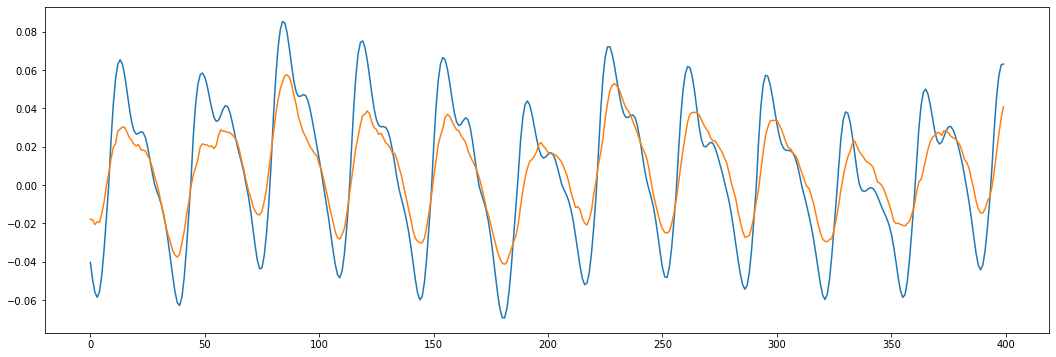

In [38]:
model = ml

test_subject = 5
smoothing_window = 10
ground_truth_smoothing_window = 20

beg = 1000
end = 1400

test_X = model.X.to_numpy()
test_y = model.y.to_numpy()

pred = ml.predict_skl(test_X)
pred = n_moving_avg(pred, smoothing_window)
pred = resample(pred, len(test_y))

plt.plot(test_y[beg: end])
plt.plot(pred[beg: end])


# =======

# pred = ml.predict_skl(ml.X.to_numpy())
# pred = n_moving_avg(pred, 10)
# pred = resample(pred, len(truth.bvp[1: ][beg: end]))

# bvp = truths[test_subject - 1].bvp[1: ][beg: end]
# # if len(pred) == len(bvp):
# #     plt.plot(bvp[0: 1000])
# #     plt.plot(pred[0: 1000])
# # else:
# #     print(len(pred), len(bvp))

# plt.plot(bvp)
# plt.plot(pred)

# ======

# beg = 0
# end = 1000

# test_data = truths[test_subject - 1].prepare_data_for_ml()
# test_X = test_data.drop(columns = ['bvp']).to_numpy()
# test_y = test_data.bvp.to_numpy()

# pred = model.predict_skl(test_X)
# pred = n_moving_avg(pred, smoothing_window)
# pred = resample(pred, len(test_y))
# signal = pred[beg: end]

# gt = n_moving_avg(test_y, ground_truth_smoothing_window)
# gt = test_y[beg: end]

# signal = normalize_signal(signal)
# signal = normalize_amplitude_to_1(signal)
# gt = normalize_signal(gt)
# gt = normalize_amplitude_to_1(gt)

# plt.plot(gt)
# plt.plot(signal)